# Customer Churn Prediction - MLflow Organized

## From Chaos to Reproducibility

In the previous notebook (`01_messy_notebook.ipynb`), we experienced typical data science chaos:
- Multiple experiments with no tracking
- Metrics scattered across cells
- "Which model was best again?"
- No versioning or reproducibility

**In this notebook, we solve these problems with MLflow:**
- Experiment tracking (parameters, metrics, artifacts)
- Model versioning and registry
- Easy comparison between runs
- Reproducible results

---

## 1. Setup and Imports

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# NEW: MLflow imports
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient

print(f"MLflow version: {mlflow.__version__}")

MLflow version: 3.9.0


## 2. MLflow Configuration

MLflow needs to know:
1. **Where to store tracking data** (tracking URI)
2. **Which experiment to log to** (experiment name)

**For this workshop:** Start the MLflow server first with `cd docker && docker-compose up -d`

In [99]:
# Set up MLflow tracking
# Connect to Docker-hosted MLflow server (start with: docker-compose up -d)
mlflow.set_tracking_uri("http://localhost:5000")

# Create or get experiment
experiment_name = "customer-churn-prediction"
mlflow.set_experiment(experiment_name)

print(f"Tracking URI: {mlflow.get_tracking_uri()}")
print(f"Experiment: {experiment_name}")

# Test connection with a simple ping
try:
    import requests
    response = requests.get(f"{mlflow.get_tracking_uri()}/health")
    print(f"✅ MLflow server responding: {response.status_code}")
except Exception as e:
    print(f"❌ Cannot connect to MLflow server: {e}")

Tracking URI: http://localhost:5000
Experiment: customer-churn-prediction
✅ MLflow server responding: 200


## 3. Load Data

We load the customer data from CSV. Run `python generate_sample_data.py` first if the file doesn't exist.

In [100]:
# Load customer data from CSV
df = pd.read_csv('../data/customer_data.csv')

print(f"Dataset shape: {df.shape}")
print(f"Churn rate: {df['churned'].mean():.2%}")
df.head()

Dataset shape: (5000, 10)
Churn rate: 49.04%


,customer_id,recency_days,frequency,monetary_value,avg_order_value,days_since_signup,total_orders,support_tickets,age,churned
0,1,156,9,6800.38,759.81,596,9,0,18,1
1,2,66,14,792.94,94.69,393,7,0,29,0
2,3,97,3,1005.08,285.39,367,3,0,37,1
3,4,1,11,2844.91,404.44,367,6,0,38,0
4,5,19,5,1749.75,136.75,1084,12,2,18,1


## 4. Feature Engineering

Same features as before - we'll track which features we use in MLflow.

In [101]:
def engineer_features(df):
    """Create engineered features - encapsulated in a function for reproducibility"""
    df = df.copy()
    
    # Ratio features
    df['recency_frequency_ratio'] = df['recency_days'] / (df['frequency'] + 1)
    df['monetary_per_order'] = df['monetary_value'] / (df['total_orders'] + 1)
    df['order_frequency'] = df['total_orders'] / (df['days_since_signup'] + 1)
    df['support_per_order'] = df['support_tickets'] / (df['total_orders'] + 1)
    
    # RFM score
    df['r_score'] = pd.qcut(df['recency_days'], q=5, labels=[5, 4, 3, 2, 1]).astype(int)
    df['f_score'] = pd.qcut(df['frequency'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5]).astype(int)
    df['m_score'] = pd.qcut(df['monetary_value'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5]).astype(int)
    df['rfm_score'] = df['r_score'] + df['f_score'] + df['m_score']
    
    return df

# Apply feature engineering
df = engineer_features(df)
print(f"Features after engineering: {df.shape[1]} columns")

Features after engineering: 18 columns


In [102]:
# Define feature columns (we'll log this to MLflow)
FEATURE_COLS = [
    'recency_days', 'frequency', 'monetary_value', 'avg_order_value',
    'days_since_signup', 'total_orders', 'support_tickets', 'age',
    'recency_frequency_ratio', 'monetary_per_order', 'order_frequency',
    'support_per_order', 'rfm_score'
]

X = df[FEATURE_COLS]
y = df['churned']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training samples: 4000
Test samples: 1000


## 5. MLflow Experiment Tracking

Now the magic happens! Instead of printing metrics and forgetting them, we **log everything to MLflow**.

### Key MLflow Concepts:
- **Run**: A single execution of your code (one experiment)
- **Parameters**: Inputs to your model (hyperparameters)
- **Metrics**: Outputs/results (accuracy, F1, etc.)
- **Artifacts**: Files (models, plots, data samples)
- **Tags**: Metadata (author, version, notes)

### 5.1 Manual Logging Example

**What we log:**
- **Parameters**: Hyperparameters, feature count, train/test sizes
- **Metrics**: Accuracy, precision, recall, F1
- **Artifacts**: Model, confusion matrix, feature importance
- **Evaluation Tables**: Detailed predictions table
- **Dataset**: Training data info (like autolog does)

**Note:** Ensure autologging is disabled before manual logging to avoid conflicts.

In [103]:
# Ensure autologging is disabled to avoid conflicts
mlflow.sklearn.autolog(disable=True)

import tempfile
import os

def train_and_log_model(model, model_name, X_train, X_test, y_train, y_test, params=None):
    """
    Train a model and log everything to MLflow.
    Includes: parameters, metrics, model, artifacts, evaluation results, and dataset.
    """
    with mlflow.start_run(run_name=model_name):
        # Log tags (metadata)
        mlflow.set_tag("model_type", model_name)
        mlflow.set_tag("author", "workshop")
        mlflow.set_tag("stage", "experimentation")
        
        # === Log dataset (like autolog does) ===
        train_data = X_train.copy()
        train_data['target'] = y_train.values
        dataset = mlflow.data.from_pandas(
            train_data, 
            source="../data/customer_data.csv",
            name="customer_churn_training",
            targets="target"
        )
        mlflow.log_input(dataset, context="training")
        
        # Log parameters
        if params:
            mlflow.log_params(params)
        mlflow.log_param("n_features", len(FEATURE_COLS))
        mlflow.log_param("train_size", len(X_train))
        mlflow.log_param("test_size", len(X_test))
        
        # Train model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
        
        # Calculate and log metrics
        metrics = {
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred),
            "f1": f1_score(y_test, y_pred)
        }
        mlflow.log_metrics(metrics)
        
        # Log evaluation results as CSV using tempfile (no local file left behind)
        eval_df = pd.DataFrame({
            'actual': y_test.values,
            'predicted': y_pred,
            'probability': y_proba if y_proba is not None else [None] * len(y_pred),
            'correct': (y_test.values == y_pred).astype(int)
        })
        with tempfile.TemporaryDirectory() as tmpdir:
            csv_path = os.path.join(tmpdir, "evaluation_results.csv")
            eval_df.to_csv(csv_path, index=False)
            mlflow.log_artifact(csv_path)
        
        # Log the model
        mlflow.sklearn.log_model(model, name="model")
        
        # Log feature importance (if available) - using log_figure (no local file)
        if hasattr(model, 'feature_importances_'):
            fig, ax = plt.subplots(figsize=(10, 6))
            feat_imp = pd.Series(model.feature_importances_, index=FEATURE_COLS)
            feat_imp.sort_values().plot(kind='barh', ax=ax)
            ax.set_title(f'Feature Importance - {model_name}')
            plt.tight_layout()
            mlflow.log_figure(fig, "feature_importance.png")
            plt.close()
        
        # Log confusion matrix - using log_figure (no local file)
        cm = confusion_matrix(y_test, y_pred)
        fig, ax = plt.subplots(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_title(f'Confusion Matrix - {model_name}')
        plt.tight_layout()
        mlflow.log_figure(fig, "confusion_matrix.png")
        plt.close()
        
        run_id = mlflow.active_run().info.run_id
        print(f"Model: {model_name} | Accuracy: {metrics['accuracy']:.4f} | F1: {metrics['f1']:.4f}")
        print(f"Logged: model, dataset, confusion matrix, evaluation CSV")
        
        return run_id, metrics

### 5.2 Run Experiments

### Preprocessing Artifacts

**Important:** Models requiring preprocessing (scaling, encoding) must save those objects as artifacts!

- At inference time, you need the **same** scaler used during training
- Without it, predictions will be incorrect (wrong scale = wrong results)

In [104]:
# Experiment 1: Logistic Regression (with preprocessing artifact)
import joblib

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

with mlflow.start_run(run_name="LogisticRegression") as run:
    # Log tags
    mlflow.set_tag("model_type", "LogisticRegression")
    mlflow.set_tag("author", "workshop")
    mlflow.set_tag("stage", "experimentation")
    mlflow.set_tag("requires_scaling", "true")
    
    # === Log dataset (like autolog does) ===
    train_data = X_train.copy()
    train_data['target'] = y_train.values
    dataset = mlflow.data.from_pandas(
        train_data,
        source="../data/customer_data.csv",
        name="customer_churn_training",
        targets="target"
    )
    mlflow.log_input(dataset, context="training")
    
    # Save the scaler as an artifact using tempfile (no local file left behind)
    with tempfile.TemporaryDirectory() as tmpdir:
        scaler_path = os.path.join(tmpdir, "scaler.pkl")
        joblib.dump(scaler, scaler_path)
        mlflow.log_artifact(scaler_path, artifact_path="preprocessing")
    
    # Log parameters
    mlflow.log_params({
        "max_iter": 1000,
        "solver": "lbfgs",
        "n_features": len(FEATURE_COLS),
        "train_size": len(X_train_scaled),
        "test_size": len(X_test_scaled)
    })
    
    # Train model
    lr = LogisticRegression(random_state=42, max_iter=1000)
    lr.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = lr.predict(X_test_scaled)
    y_proba = lr.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate and log metrics
    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred)
    }
    mlflow.log_metrics(metrics)
    
    # Log evaluation results as CSV using tempfile (no local file left behind)
    eval_df = pd.DataFrame({
        'actual': y_test.values,
        'predicted': y_pred,
        'probability': y_proba,
        'correct': (y_test.values == y_pred).astype(int)
    })
    with tempfile.TemporaryDirectory() as tmpdir:
        csv_path = os.path.join(tmpdir, "evaluation_results.csv")
        eval_df.to_csv(csv_path, index=False)
        mlflow.log_artifact(csv_path)
    
    # Log the model (use name= instead of deprecated artifact_path=)
    mlflow.sklearn.log_model(lr, name="model")
    
    # Log confusion matrix - using log_figure (no local file)
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title('Confusion Matrix - LogisticRegression')
    plt.tight_layout()
    mlflow.log_figure(fig, "confusion_matrix.png")
    plt.close()
    
    lr_run_id = run.info.run_id
    lr_metrics = metrics
    
    print(f"Model: LogisticRegression | Accuracy: {metrics['accuracy']:.4f} | F1: {metrics['f1']:.4f}")
    print(f"Logged: model, dataset, scaler, confusion matrix, evaluation CSV")

2026/02/18 02:58:39 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Model: LogisticRegression | Accuracy: 0.8050 | F1: 0.7992
Logged: model, dataset, scaler, confusion matrix, evaluation CSV
🏃 View run LogisticRegression at: http://localhost:5000/#/experiments/1/runs/0a50f51fe6f84bd89bec626ee0b7fcef
🧪 View experiment at: http://localhost:5000/#/experiments/1


In [105]:
# Experiment 2: Random Forest (default params)
rf1 = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf1_run_id, rf1_metrics = train_and_log_model(
    rf1,
    "RandomForest_v1",
    X_train, X_test, y_train, y_test,
    params={"n_estimators": 100, "max_depth": None, "min_samples_split": 2}
)

2026/02/18 02:59:14 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Model: RandomForest_v1 | Accuracy: 0.7770 | F1: 0.7722
Logged: model, dataset, confusion matrix, evaluation CSV
🏃 View run RandomForest_v1 at: http://localhost:5000/#/experiments/1/runs/d8c21a2371084aba9f2af02c5fae80d7
🧪 View experiment at: http://localhost:5000/#/experiments/1


In [106]:
# Experiment 3: Random Forest (tuned)
rf2 = RandomForestClassifier(
    n_estimators=200, 
    max_depth=10, 
    min_samples_split=20,
    random_state=42, 
    n_jobs=-1
)
rf2_run_id, rf2_metrics = train_and_log_model(
    rf2,
    "RandomForest_v2_tuned",
    X_train, X_test, y_train, y_test,
    params={"n_estimators": 200, "max_depth": 10, "min_samples_split": 20}
)

2026/02/18 02:59:21 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Model: RandomForest_v2_tuned | Accuracy: 0.7910 | F1: 0.7861
Logged: model, dataset, confusion matrix, evaluation CSV
🏃 View run RandomForest_v2_tuned at: http://localhost:5000/#/experiments/1/runs/bdb93b1c8cbe419db749e0fa9c485794
🧪 View experiment at: http://localhost:5000/#/experiments/1


In [107]:
# Experiment 4: Gradient Boosting
gb = GradientBoostingClassifier(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=5, 
    random_state=42
)
gb_run_id, gb_metrics = train_and_log_model(
    gb,
    "GradientBoosting",
    X_train, X_test, y_train, y_test,
    params={"n_estimators": 100, "learning_rate": 0.1, "max_depth": 5}
)

2026/02/18 02:59:30 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Model: GradientBoosting | Accuracy: 0.7970 | F1: 0.7931
Logged: model, dataset, confusion matrix, evaluation CSV
🏃 View run GradientBoosting at: http://localhost:5000/#/experiments/1/runs/a418f321dfe0484cb0e9aae5d4a32664
🧪 View experiment at: http://localhost:5000/#/experiments/1


In [108]:
# Experiment 5: Gradient Boosting (different params)
gb2 = GradientBoostingClassifier(
    n_estimators=200, 
    learning_rate=0.05, 
    max_depth=4, 
    random_state=42
)
gb2_run_id, gb2_metrics = train_and_log_model(
    gb2,
    "GradientBoosting_v2",
    X_train, X_test, y_train, y_test,
    params={"n_estimators": 200, "learning_rate": 0.05, "max_depth": 4}
)

2026/02/18 02:59:39 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Model: GradientBoosting_v2 | Accuracy: 0.7850 | F1: 0.7790
Logged: model, dataset, confusion matrix, evaluation CSV
🏃 View run GradientBoosting_v2 at: http://localhost:5000/#/experiments/1/runs/9044af6f1a354eeab807a1ffff4c43fc
🧪 View experiment at: http://localhost:5000/#/experiments/1


### 5.3 Alternative: Autologging

MLflow can automatically log parameters and metrics for supported frameworks!

**Autolog captures:**
- **All parameters** (including defaults like `bootstrap=True`, `ccp_alpha=0.0`, etc.)
- **Training metrics** with different names: `training_accuracy_score`, `training_f1_score`, etc.
- **Model artifact** and signature
- **Dataset info** (input schema, sample rows)
- **Feature importances** (for tree-based models)

**Trade-offs:**
| Manual Logging | Autologging |
|----------------|-------------|
| Full control over what's logged | Logs everything automatically |
| Consistent metric names (`accuracy`) | Framework-specific names (`training_accuracy_score`) |
| Cleaner parameter list | All parameters (including defaults) |
| More code to write | Zero logging code needed |

In [109]:
# Enable autologging for sklearn
mlflow.sklearn.autolog()

# Now train without manual logging - MLflow captures everything!
with mlflow.start_run(run_name="RandomForest_autolog"):
    mlflow.set_tag("logging_method", "autolog")
    
    rf_auto = RandomForestClassifier(
        n_estimators=150, 
        max_depth=12, 
        random_state=42,
        n_jobs=-1
    )
    rf_auto.fit(X_train, y_train)
    
    # Autolog automatically captures:
    # - All model parameters (including defaults!)
    # - Training metrics (training_accuracy_score, etc.) - ON TRAINING DATA
    # - Model artifact
    # - Feature importances
    
    # IMPORTANT: Autolog metrics are on TRAINING data!
    # For fair comparison, we also log TEST metrics manually:
    y_pred = rf_auto.predict(X_test)
    mlflow.log_metrics({
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred)
    })
    
    print("Autologging captured all parameters and model automatically!")
    print(f"Note: training_* metrics are on training data (will be higher)")
    print(f"      accuracy/f1/etc are on test data (comparable to other runs)")

# Disable autolog for manual control
mlflow.sklearn.autolog(disable=True)

2026/02/18 02:59:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Autologging captured all parameters and model automatically!
Note: training_* metrics are on training data (will be higher)
      accuracy/f1/etc are on test data (comparable to other runs)
🏃 View run RandomForest_autolog at: http://localhost:5000/#/experiments/1/runs/8a27b6a682b842fd9d9252c40ee4b877
🧪 View experiment at: http://localhost:5000/#/experiments/1


## 6. Compare Experiments

Now let's see the power of MLflow - comparing all our experiments!

In [110]:
# Get all runs from our experiment
client = MlflowClient()
experiment = client.get_experiment_by_name(experiment_name)

runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    order_by=["metrics.f1 DESC"]
)

print(f"Total runs: {len(runs)}\n")
print("All experiments ranked by F1 score (TEST metrics):")
print("=" * 80)

results = []
for run in runs:
    if run.data.metrics:
        metrics = run.data.metrics
        
        # Prioritize TEST metrics (accuracy, f1, etc.)
        # Fall back to training metrics only if test metrics don't exist
        accuracy = metrics.get('accuracy', 0)
        precision = metrics.get('precision', 0)
        recall = metrics.get('recall', 0)
        f1 = metrics.get('f1', 0)
        
        # Skip runs that don't have test metrics
        if f1 == 0 and 'training_f1_score' in metrics:
            # This run only has training metrics - show but flag it
            accuracy = metrics.get('training_accuracy_score', 0)
            f1 = metrics.get('training_f1_score', 0)
            precision = metrics.get('training_precision_score', 0)
            recall = metrics.get('training_recall_score', 0)
            metric_type = "TRAIN (not comparable!)"
        else:
            metric_type = "test"
        
        logging_method = run.data.tags.get('logging_method', 'manual')
        
        results.append({
            'run_name': run.info.run_name,
            'run_id': run.info.run_id[:8],
            'metric_type': metric_type,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('f1', ascending=False).reset_index(drop=True)

print("\nNote: All runs now use TEST metrics for fair comparison.")
print("      Runs with only training metrics are flagged.\n")
results_df

Total runs: 12

All experiments ranked by F1 score (TEST metrics):

Note: All runs now use TEST metrics for fair comparison.
      Runs with only training metrics are flagged.



,run_name,run_id,metric_type,accuracy,precision,recall,f1
0,LogisticRegression,0a50f51f,test,0.805,0.806653,0.791837,0.799176
1,LogisticRegression,c275a377,test,0.805,0.806653,0.791837,0.799176
2,GradientBoosting,a418f321,test,0.797,0.792261,0.793878,0.793068
3,GradientBoosting,9ad2468a,test,0.797,0.792261,0.793878,0.793068
4,RandomForest_v2_tuned,bdb93b1c,test,0.791,0.788501,0.783673,0.786080
5,RandomForest_v2_tuned,8ae74f64,test,0.791,0.788501,0.783673,0.786080
6,RandomForest_autolog,8a27b6a6,test,0.787,0.785567,0.777551,0.781538
7,RandomForest_autolog,dbc753ae,test,0.787,0.785567,0.777551,0.781538
8,GradientBoosting_v2,9044af6f,test,0.785,0.784679,0.773469,0.779034
9,GradientBoosting_v2,6760c68f,test,0.785,0.784679,0.773469,0.779034


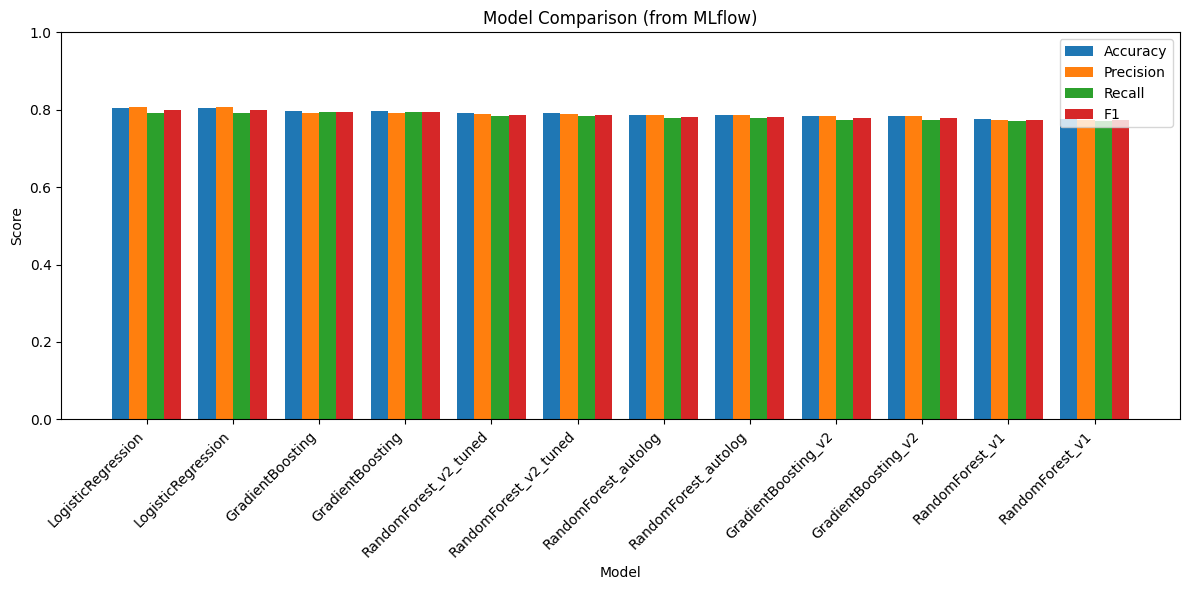

In [111]:
# Visualize comparison
if len(results_df) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = range(len(results_df))
    width = 0.2
    
    ax.bar([i - 1.5*width for i in x], results_df['accuracy'], width, label='Accuracy')
    ax.bar([i - 0.5*width for i in x], results_df['precision'], width, label='Precision')
    ax.bar([i + 0.5*width for i in x], results_df['recall'], width, label='Recall')
    ax.bar([i + 1.5*width for i in x], results_df['f1'], width, label='F1')
    
    ax.set_xlabel('Model')
    ax.set_ylabel('Score')
    ax.set_title('Model Comparison (from MLflow)')
    ax.set_xticks(x)
    ax.set_xticklabels(results_df['run_name'], rotation=45, ha='right')
    ax.legend()
    ax.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

In [112]:
# Find the best model
if len(results_df) > 0:
    best_run = results_df.loc[results_df['f1'].idxmax()]
    print(f"Best model by F1 score: {best_run['run_name']}")
    print(f"F1 Score: {best_run['f1']:.4f}")

Best model by F1 score: LogisticRegression
F1 Score: 0.7992


## 7. Model Registry

Now that we've found our best model, let's **register** it. The Model Registry provides:
- Version control for models
- Stage transitions (Staging → Production)
- Model lineage (which run created this model)

In [113]:
# Get the best run ID (by F1 score)
best_runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    filter_string="metrics.f1 > 0",
    order_by=["metrics.f1 DESC"],
    max_results=1
)

if best_runs:
    best_run = best_runs[0]
    best_run_id = best_run.info.run_id
    print(f"Best run: {best_run.info.run_name}")
    print(f"Run ID: {best_run_id}")
    print(f"F1: {best_run.data.metrics.get('f1', 0):.4f}")

Best run: LogisticRegression
Run ID: 0a50f51fe6f84bd89bec626ee0b7fcef
F1: 0.7992


In [114]:
# Register the best model
model_name = "customer-churn-classifier"

if best_runs:
    model_uri = f"runs:/{best_run_id}/model"
    
    # Register the model
    registered_model = mlflow.register_model(
        model_uri=model_uri,
        name=model_name
    )
    
    print(f"Model registered: {model_name}")
    print(f"Version: {registered_model.version}")

Registered model 'customer-churn-classifier' already exists. Creating a new version of this model...
2026/02/18 03:00:07 WARNING mlflow.tracking._model_registry.fluent: Run with id 0a50f51fe6f84bd89bec626ee0b7fcef has no artifacts at artifact path 'model', registering model based on models:/m-ef69e298a31948f1ab04693a708e0ef3 instead
2026/02/18 03:00:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: customer-churn-classifier, version 4
Created version '4' of model 'customer-churn-classifier'.


Model registered: customer-churn-classifier
Version: 4


In [115]:
# View registered model versions
try:
    versions = client.search_model_versions(f"name='{model_name}'")
    print(f"\nRegistered versions of '{model_name}':")
    print("=" * 60)
    for v in versions:
        print(f"Version {v.version}: Run ID {v.run_id[:8]}... | Status: {v.status}")
except Exception as e:
    print(f"No registered models found yet: {e}")


Registered versions of 'customer-churn-classifier':
Version 4: Run ID 0a50f51f... | Status: READY
Version 3: Run ID c275a377... | Status: READY
Version 2: Run ID a6bbbbd9... | Status: READY
Version 1: Run ID b1d6cfe2... | Status: READY


## 8. Load and Use Registered Model

In production, you load models from the registry - not from local files!

In [116]:
# Load model from registry with preprocessing artifacts
import joblib
import tempfile

try:
    # Load the latest version
    model_uri = f"models:/{model_name}/latest"
    loaded_model = mlflow.sklearn.load_model(model_uri)
    
    print(f"Loaded model: {model_name}")
    print(f"Model type: {type(loaded_model).__name__}")
    
    # Check if this model requires preprocessing
    client = MlflowClient()
    model_version = client.get_latest_versions(model_name, stages=[])[0]
    run_id = model_version.run_id
    run = client.get_run(run_id)
    
    requires_scaling = run.data.tags.get("requires_scaling", "false") == "true"
    
    if requires_scaling:
        print(f"\n⚠️  This model requires preprocessing (scaling)")
        
        # Download the scaler artifact
        artifact_path = client.download_artifacts(run_id, "preprocessing/scaler.pkl")
        scaler = joblib.load(artifact_path)
        print(f"✅ Loaded scaler from artifacts")
        
        # Apply preprocessing before prediction
        X_test_scaled = scaler.transform(X_test[:5])
        sample_predictions = loaded_model.predict(X_test_scaled)
        sample_probas = loaded_model.predict_proba(X_test_scaled)[:, 1]
        
        print("\nSample predictions (with proper preprocessing):")
        for i, (pred, proba) in enumerate(zip(sample_predictions, sample_probas)):
            actual = y_test.iloc[i]
            print(f"  Customer {i+1}: Predicted={pred}, Actual={actual}, Probability={proba:.2%}")
    else:
        # Tree-based models don't need scaling
        print(f"\n✅ This model doesn't require preprocessing")
        sample_predictions = loaded_model.predict(X_test[:5])
        sample_probas = loaded_model.predict_proba(X_test[:5])[:, 1]
        
        print("\nSample predictions:")
        for i, (pred, proba) in enumerate(zip(sample_predictions, sample_probas)):
            actual = y_test.iloc[i]
            print(f"  Customer {i+1}: Predicted={pred}, Actual={actual}, Probability={proba:.2%}")
        
except Exception as e:
    print(f"Could not load from registry: {e}")
    print("This is expected if running for the first time.")

Loaded model: customer-churn-classifier
Model type: LogisticRegression

⚠️  This model requires preprocessing (scaling)
✅ Loaded scaler from artifacts

Sample predictions (with proper preprocessing):
  Customer 1: Predicted=0, Actual=1, Probability=2.97%
  Customer 2: Predicted=1, Actual=0, Probability=75.17%
  Customer 3: Predicted=0, Actual=0, Probability=2.36%
  Customer 4: Predicted=1, Actual=1, Probability=97.34%
  Customer 5: Predicted=1, Actual=1, Probability=57.00%


### Key Takeaway

Notice how the code above:
1. **Checks the model's tags** to see if preprocessing is needed
2. **Downloads the scaler artifact** from MLflow
3. **Applies the same transformation** used during training

This is the **production-ready pattern**:
```python
# Training time
scaler.fit_transform(X_train)  # Learn from training data
mlflow.log_artifact("scaler.pkl")  # Save it!

# Inference time  
scaler = load_artifact("scaler.pkl")  # Load it!
scaler.transform(X_new)  # Apply (never fit again!)
```

**Common mistake:** Re-fitting the scaler on new data → different scale → wrong predictions!

## 9. View MLflow UI

The MLflow server is running in Docker. Open http://localhost:5000 in your browser.

You'll see:
- All experiments and runs
- Parameter and metric comparison
- Artifact browser (models, plots)
- Model registry

**Note:** If you haven't started the server yet, run:
```bash
cd docker && docker-compose up -d
```

---

## Summary: What MLflow Solved

| Problem (Messy Notebook) | Solution (MLflow) |
|--------------------------|-------------------|
| "Which model was best?" | Query runs by metrics |
| Metrics scattered in cells | Centralized metric storage |
| No versioning | Model Registry with versions |
| Can't reproduce | Run ID links to exact code/params |
| Manual comparison | Automatic comparison UI |
| Lost model files | Artifacts stored with run |

## What's Still Manual?

MLflow doesn't solve everything:
- **Scheduling**: How to run this daily?
- **Dependencies**: What if data loading fails?
- **Alerting**: How to know if training failed?
- **CI/CD**: How to automate deployment?

**Next step**: Orchestrators (Prefect, Airflow, Dagster) to automate the pipeline!

---

## Exercises

1. **Add a new model**: Try XGBoost or LightGBM and log it to MLflow
2. **Hyperparameter search**: Run multiple experiments with different parameters
3. **Custom metrics**: Log a custom metric (e.g., AUC-ROC)
4. **Model comparison**: Use the MLflow UI to compare your experiments
5. **Registry workflow**: Register your best model and load it back